In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# 0️⃣ Install / upgrade required packages
# (Run this cell first in Colab Pro)
!pip install -q --upgrade transformers accelerate bitsandbytes torch

# ─────────────────────────────────────────────────────────────────────────────


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.6 MB/s eta 0:00:00


In [2]:
# ────────────────────────────────────────────────────────────────────────────
# 1️⃣ Imports & device
import os, re, time
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# If you need to authenticate for private or gated models:
token = os.getenv("HF_TOKEN")  # ✅ much safer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# ────────────────────────────────────────────────────────────────────────────
# 2️⃣ Load & slice one year of data (8 640 hourly temps)
df = (
    pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
      .sort_values("Formatted Date")
      .reset_index(drop=True)
)
FEATURE = "Temperature (C)"
LOOKBACK = 8640   # 1 year of hourly samples
HORIZON  = 720    # 30 days × 24 h

temps = df[FEATURE].values[-LOOKBACK:]
assert temps.shape[0] == LOOKBACK
# ────────────────────────────────────────────────────────────────────────────
# 3️⃣ Build the direct multi‑step prompt
# WARNING: this is very long—ensure your context size can hold ~8640 tokens + space for 720 outputs.
temps_list = [round(float(x),1) for x in temps]
# join without spaces to save tokens; you can also downsample if you hit truncation
input_str = ",".join(str(x) for x in temps_list)

prompt = (
    f"Given the past {LOOKBACK} hourly temperatures: [{input_str}], "
    f"predict the next {HORIZON} hourly temperatures. "
    "Reply with a comma‑separated list of numbers."
)
# ────────────────────────────────────────────────────────────────────────────
# 4️⃣ Load Mistral‑7B FP16 via Accelerate
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=os.environ["HF_TOKEN"],
    torch_dtype=torch.float16,
    device_map="cuda"   # ⚠️ this loads everything into GPU
)


model.eval()
# ────────────────────────────────────────────────────────────────────────────
# 5️⃣ Tokenize, generate, and time it
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    truncation=True,
    max_length=8192  # adjust if you have a longer context window
).to(device)

start = time.time()
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4096,   # allow space for up to ~4k tokens of answers
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
elapsed = time.time() - start
print(f"Single-shot generation took {elapsed:.1f} seconds")
# ────────────────────────────────────────────────────────────────────────────
# 6️⃣ Decode & parse out 720 floats
resp = tokenizer.decode(outputs[0], skip_special_tokens=True)
nums = re.findall(r"[-+]?\d*\.\d+|\d+", resp)
preds = [float(x) for x in nums[:HORIZON]]

print(f"Parsed {len(preds)} hourly predictions:")
print(preds)


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Single-shot generation took 206.5 seconds
Parsed 720 hourly predictions:
[8640.0, -0.0, 0.0, 0.0, 0.0, 0.1, -0.0, -0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, -0.1, -2.1, -2.9, -4.0, -3.4, -6.7, -4.7, -4.5, -5.6, -5.1, -4.5, -4.0, -3.0, -3.0, -2.9, -2.9, -2.8, -2.8, -2.8, -2.0, -1.2, -1.1, -1.1, -1.1, -0.1, -0.1, -0.1, -0.5, -0.4, -0.5, -0.0, 0.1, 0.0, 0.5, 0.6, 1.1, 1.0, 1.0, 1.1, 1.1, 2.1, 2.1, 2.1, 2.4, 2.2, 2.2, 2.5, 2.1, 2.1, 2.8, 2.6, 2.6, 2.0, 3.2, 3.2, 2.5, 2.6, 3.7, 3.8, 3.7, 4.7, 4.9, 5.8, 5.9, 6.0, 6.9, 6.9, 7.3, 5.9, 4.9, 4.1, 2.2, 1.1, 0.4, 0.0, 0.0, 0.3, 0.5, 2.7, 3.4, 4.2, 4.2, 4.4, 3.6, 4.6, 4.7, 6.8, 8.4, 10.1, 10.7, 12.4, 12.5, 13.7, 12.6, 12.1, 12.1, 12.1, 11.0, 11.0, 12.0, 11.0, 10.7, 8.7, 7.3, 6.5, 6.6, 6.0, 6.0, 5.0, 4.9, 5.9, 6.0, 7.4, 7.1, 7.9, 9.9, 11.1, 10.0, 7.7, 6.1, 6.0, 5.0, 5.2, 5.1, 5.4, 3.3, 2.2, 1.7, 1.7, 0.7, 0.2, 0.0, 0.0, 1.1, 1.2, 2.8, 5.1, 7.6, 7.6, 7.7, 7.6, 7.2, 5.1, 3.9, 3.9, 3.8, 3.9, 4.4, 3.8, 2.7, 3.3, 3.1, 2.8, 3.7, 2.5, 2.1

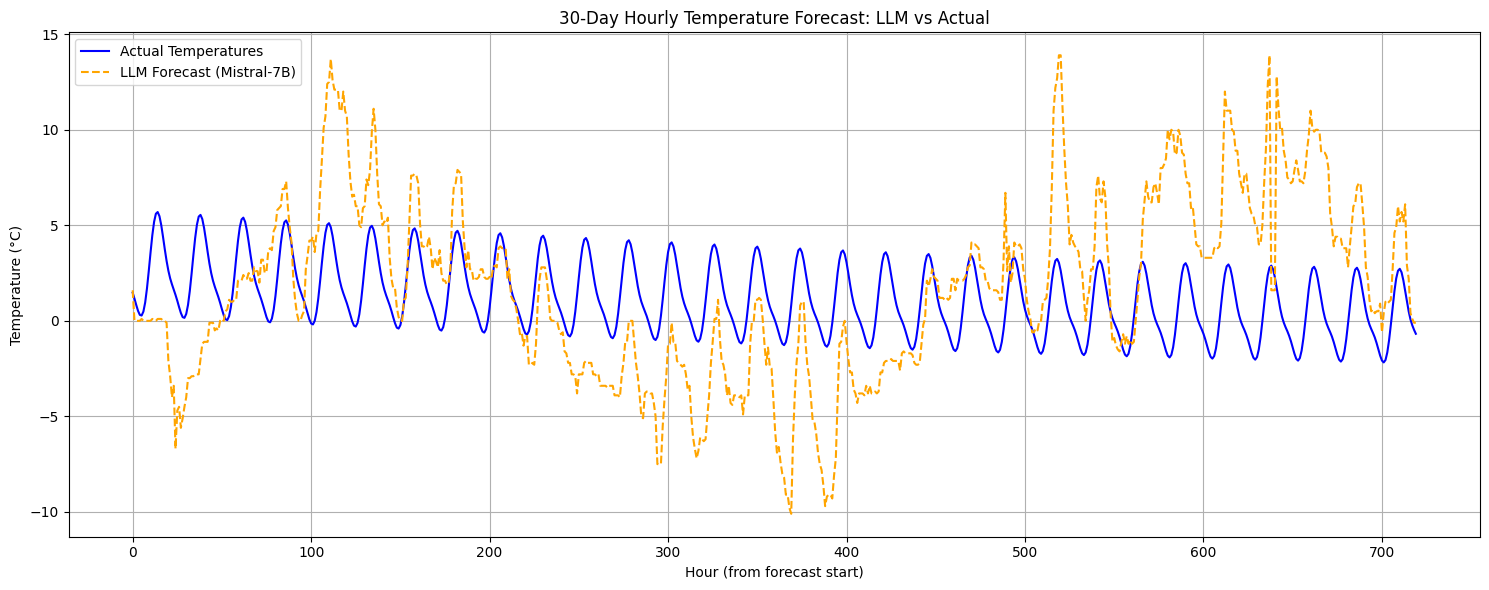

In [5]:
import matplotlib.pyplot as plt
import numpy as np
next_month_actual = df[FEATURE].values[-HORIZON:]
llm_preds = preds

# Convert to numpy arrays
actual = np.array(next_month_actual)
preds = np.array(llm_preds)

# --- IQR Outlier Removal ---
Q1 = np.percentile(preds, 25)
Q3 = np.percentile(preds, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outlier_indices = np.where((preds < lower_bound) | (preds > upper_bound))[0]

# Create a cleaned array by replacing outliers with a more reasonable value
# You can choose to replace with NaN, the median, or the bounds
preds_cleaned_iqr = np.copy(preds) # Create a copy to avoid modifying the original
median_pred = np.median(preds)
preds_cleaned_iqr[outlier_indices] = median_pred # Replace outliers with the median

# Time index
hours = np.arange(len(actual))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(hours, actual, label="Actual Temperatures", color='blue')
plt.plot(hours, preds_cleaned_iqr, label="LLM Forecast (Mistral-7B)", color='orange', linestyle='--')
plt.xlabel("Hour (from forecast start)")
plt.ylabel("Temperature (°C)")
plt.title("30-Day Hourly Temperature Forecast: LLM vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
!pip install prophet -q


In [7]:
from prophet import Prophet
import pandas as pd

# Load and sort the dataset
df = pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
df = df.sort_values("Formatted Date").reset_index(drop=True)

# Step 1: Ensure datetime is parsed correctly and convert to UTC first
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)

# Step 2: Then remove timezone (convert to naive datetime)
df["Formatted Date"] = df["Formatted Date"].dt.tz_localize(None)

# Step 3: Prepare dataframe for Prophet
df_prophet = df[["Formatted Date", "Temperature (C)"]].rename(
    columns={"Formatted Date": "ds", "Temperature (C)": "y"}
)

# Split data into train and test (last 720 hours as test set)
train_df = df_prophet[:-720]
test_df = df_prophet[-720:]

# Step 4: Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Step 5: Forecast next 720 hours
future = prophet_model.make_future_dataframe(periods=720, freq='H')
forecast = prophet_model.predict(future)

# Step 6: Extract predictions
prophet_preds = forecast[-720:]["yhat"].values
next_month_actual = test_df["y"].values

print("✅ Forecast complete. Prophet predicted", len(prophet_preds), "values.")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpldi5axi7/dvxhxk2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpldi5axi7/5eywrqpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92581', 'data', 'file=/tmp/tmpldi5axi7/dvxhxk2f.json', 'init=/tmp/tmpldi5axi7/5eywrqpd.json', 'output', 'file=/tmp/tmpldi5axi7/prophet_modelu6oawhvv/prophet_model-20250422220720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


✅ Forecast complete. Prophet predicted 720 values.


<ipython-input-8-73e7f8d171a3>:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


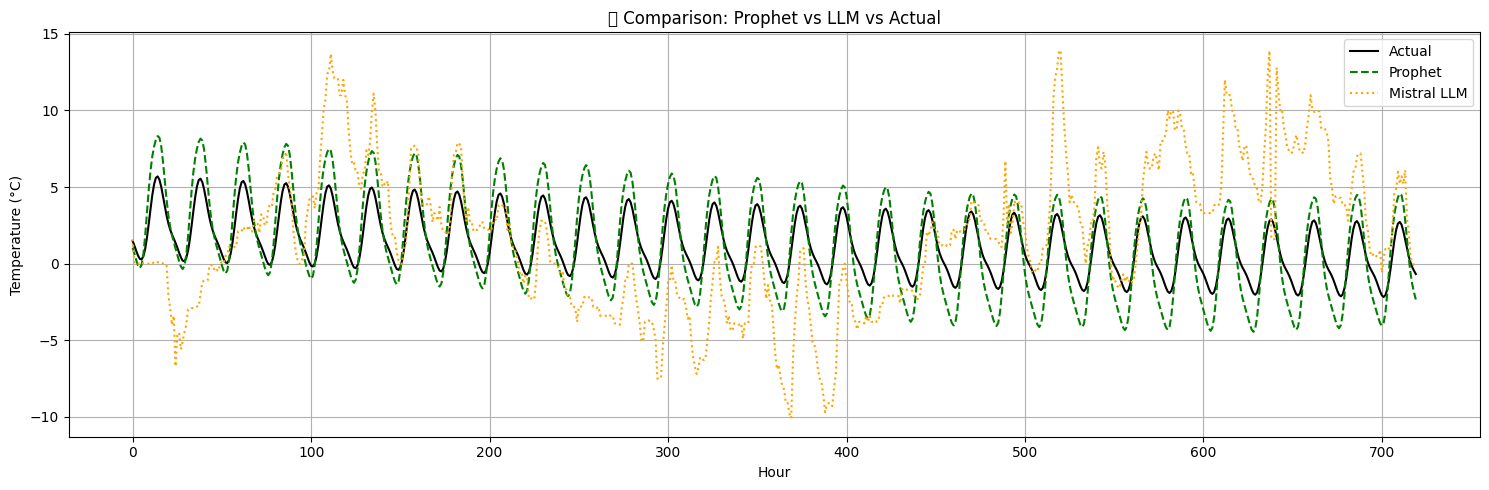


🔎 Prophet Metrics:
  RMSE : 1.5413
  MAE  : 1.3587
  R²   : 0.3189

🔎 Mistral LLM Metrics:
  RMSE : 4.7072
  MAE  : 3.8981
  R²   : -5.3534


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Create time axis
time = np.arange(720)

# ========== 📊 PLOT 3: Prophet vs LLM vs Actual ==========
plt.figure(figsize=(15, 5))
plt.plot(time, next_month_actual, label="Actual", color="black")
plt.plot(time, prophet_preds, label="Prophet", color="green", linestyle="--")
plt.plot(time, preds_cleaned_iqr, label="Mistral LLM", color="orange", linestyle=":")
plt.title("📈 Comparison: Prophet vs LLM vs Actual")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 📐 METRICS ==========
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Manual RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n🔎 {name} Metrics:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

print_metrics("Prophet", next_month_actual, prophet_preds)
print_metrics("Mistral LLM", next_month_actual, preds_cleaned_iqr)

In [9]:
import pandas as pd

# Create DataFrame with hourly index
hours = list(range(720))

# Save predictions and actual values
results_df = pd.DataFrame({
    "Hour": hours,
    "Actual_Temp": next_month_actual,
    "Prophet_Pred": prophet_preds,
    "LLM_Pred": preds_cleaned_iqr
})

# Save to CSV
# results_df.to_csv("temperature_forecast_comparison.csv", index=False)
# print("✅ Saved to temperature_forecast_comparison.csv")


Generating predictions for validation period 1...
Generation for validation period 1 took 205.2 seconds
Completed validation period 1
Generating predictions for validation period 2...
Generation for validation period 2 took 205.4 seconds
Completed validation period 2
Found 4 outliers in validation period 1
Found 1 outliers in validation period 2
Replaced 5 outliers out of 1440 total points (0.35%)


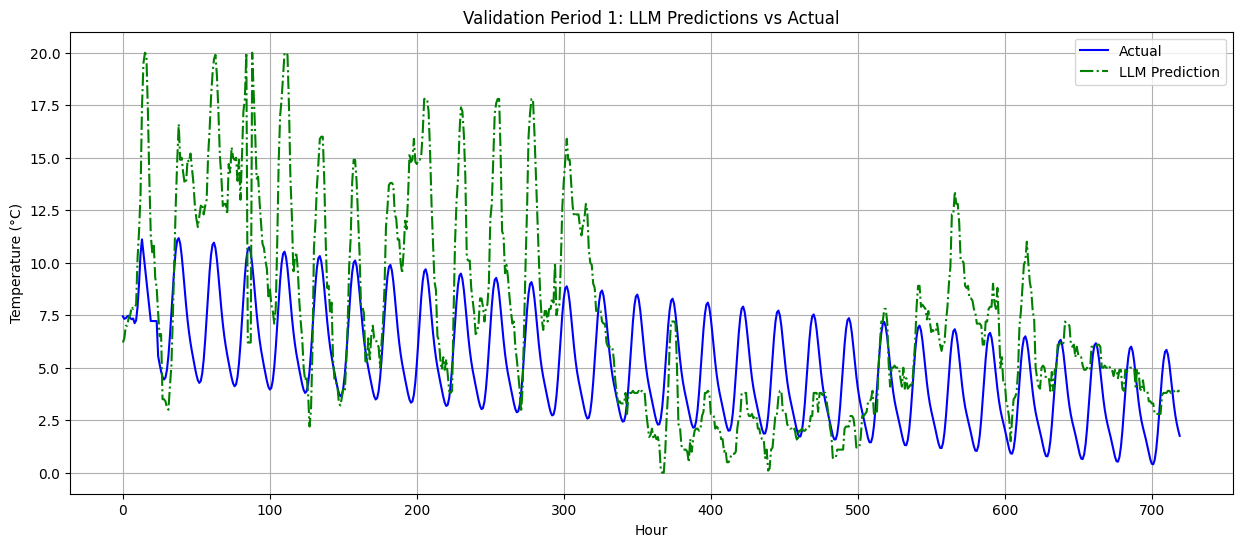

In [10]:
# ────────────────────────────────────────────────────────────────────────────
# 7️⃣ Create Validation Set and Generate LLM Predictions for it
import os, re, time
from transformers import AutoTokenizer, AutoModelForCausalLM

# Keep your existing imports and setup

# Parameters
FEATURE = "Temperature (C)"
LOOKBACK = 8640   # 1 year of hourly samples
HORIZON = 720     # 30 days × 24 h
VALIDATION_PERIODS = 2  # Number of validation periods to create


# Create validation sets
# We'll take 3 periods before the current forecast period
validation_predictions = []
validation_actuals = []

# Get the full data series
full_temps = df[FEATURE].values

# Define validation start points
# We'll work backwards from the end of the data, before the forecast period
total_data_points = len(full_temps) - HORIZON  # Exclude forecast period
for i in range(VALIDATION_PERIODS):
    # Calculate start and end indices for this validation period
    val_end_idx = total_data_points - i * HORIZON
    val_start_idx = val_end_idx - HORIZON
    train_end_idx = val_start_idx
    train_start_idx = train_end_idx - LOOKBACK

    # Make sure we have enough data
    if train_start_idx < 0:
        print(f"Warning: Not enough data for validation period {i+1}. Skipping.")
        continue

    # Extract training and validation data for this period
    train_temps = full_temps[train_start_idx:train_end_idx]
    val_actual_temps = full_temps[val_start_idx:val_end_idx]

    # Build prompt for this validation period
    temps_list = [round(float(x),1) for x in train_temps]
    input_str = ",".join(str(x) for x in temps_list)

    val_prompt = (
        f"Given the past {LOOKBACK} hourly temperatures: [{input_str}], "
        f"predict the next {HORIZON} hourly temperatures. "
        "Reply with a comma‑separated list of numbers."
    )

    # Generate predictions using the model
    print(f"Generating predictions for validation period {i+1}...")

    # Load model if not already loaded
    if 'model' not in locals():
        model_name = "mistralai/Mistral-7B-Instruct-v0.1"

        tokenizer = AutoTokenizer.from_pretrained(model_name, token=os.environ.get("HF_TOKEN"))
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            token=os.environ.get("HF_TOKEN"),
            torch_dtype=torch.float16,
            device_map="cuda"
        )
        model.eval()

    # Tokenize
    val_inputs = tokenizer(
        val_prompt,
        return_tensors="pt",
        truncation=True,
        max_length=8192
    ).to(model.device)

    # Generate predictions
    start = time.time()
    with torch.no_grad():
        val_outputs = model.generate(
            **val_inputs,
            max_new_tokens=4096,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    elapsed = time.time() - start
    print(f"Generation for validation period {i+1} took {elapsed:.1f} seconds")

    # Decode and parse predictions
    val_resp = tokenizer.decode(val_outputs[0], skip_special_tokens=True)
    val_nums = re.findall(r"[-+]?\d*\.\d+|\d+", val_resp)
    val_preds = [float(x) for x in val_nums[:HORIZON]]

    # Ensure we got the right number of predictions
    if len(val_preds) < HORIZON:
        print(f"Warning: Only got {len(val_preds)} predictions for validation period {i+1}")
        # Pad with the last value if needed
        val_preds.extend([val_preds[-1]] * (HORIZON - len(val_preds)))

    # Store data for this validation period
    validation_predictions.append(val_preds)
    validation_actuals.append(val_actual_temps)

    print(f"Completed validation period {i+1}")

# Convert lists to numpy arrays for easier processing
validation_predictions = np.array(validation_predictions)
validation_actuals = np.array(validation_actuals)

# Apply IQR outlier detection and replacement for each validation period
validation_predictions_cleaned = np.copy(validation_predictions)

for i in range(len(validation_predictions)):
    # Get predictions for this validation period
    period_preds = validation_predictions[i]

    # Calculate IQR
    Q1 = np.percentile(period_preds, 25)
    Q3 = np.percentile(period_preds, 75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_indices = np.where((period_preds < lower_bound) | (period_preds > upper_bound))[0]

    # Calculate median for replacement
    median_pred = np.median(period_preds)

    # Replace outliers with median
    if len(outlier_indices) > 0:
        print(f"Found {len(outlier_indices)} outliers in validation period {i+1}")
        validation_predictions_cleaned[i, outlier_indices] = median_pred

# Print summary of cleaning
total_outliers = np.sum(validation_predictions != validation_predictions_cleaned)
total_points = validation_predictions.size
print(f"Replaced {total_outliers} outliers out of {total_points} total points ({total_outliers/total_points*100:.2f}%)")

# Plot one validation period as an example with both raw and cleaned predictions
plt.figure(figsize=(15, 6))
plt.plot(validation_actuals[0], label='Actual', color='blue')
plt.plot(validation_predictions_cleaned[0], label='LLM Prediction', color='green', linestyle='-.')
plt.title(f'Validation Period 1: LLM Predictions vs Actual')
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


Training regression model on 1440 validation examples
Training Linear Regression...
Linear Regression - MSE: 10.7131, MAE: 2.6456, R2: 0.2174
Training Ridge Regression...
Ridge Regression - MSE: 10.7131, MAE: 2.6456, R2: 0.2174
Training Random Forest...
Random Forest - MSE: 8.6794, MAE: 2.3302, R2: 0.3660
Training Gradient Boosting...
Gradient Boosting - MSE: 9.1718, MAE: 2.4205, R2: 0.3300
Training Neural Network...
Neural Network - MSE: 10.4916, MAE: 2.6212, R2: 0.2336

Best model based on MSE: Random Forest

Applying correction model to the forecast data...

Original Forecast - MSE: 22.1575, MAE: 3.8981
Corrected Forecast - MSE: 23.2981, MAE: 4.2372
Improvement: -5.15% reduction in MSE


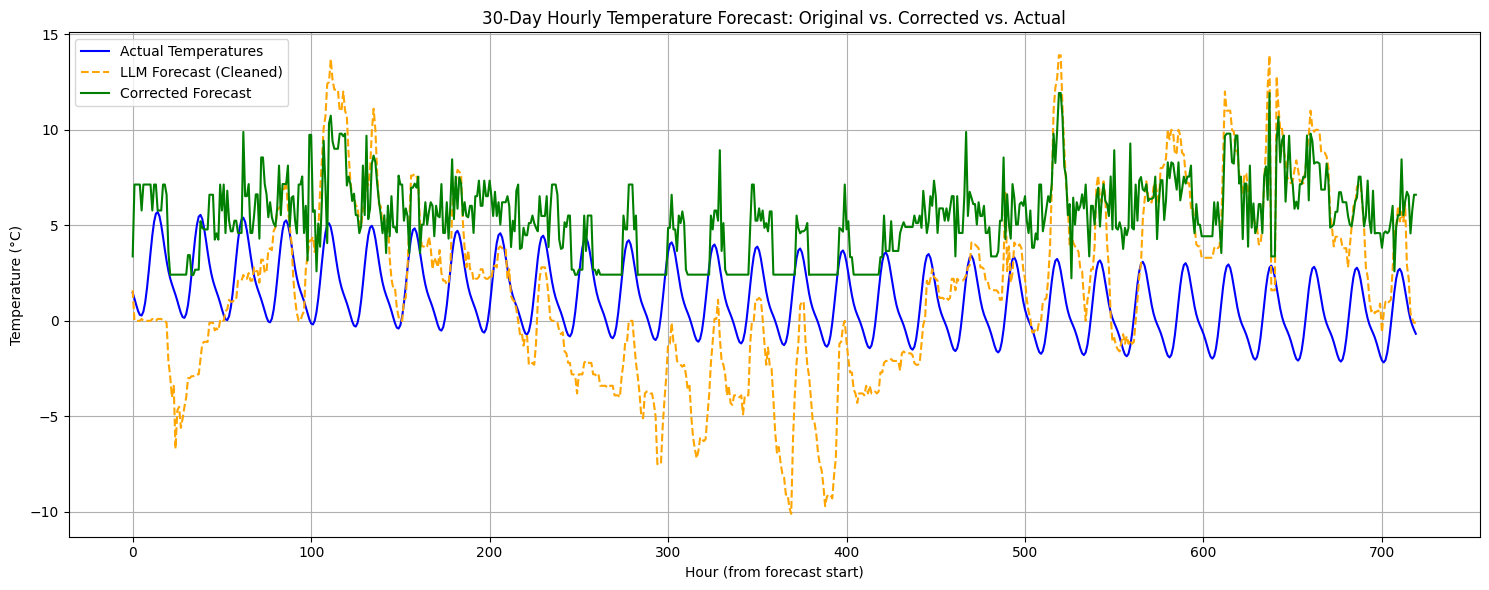

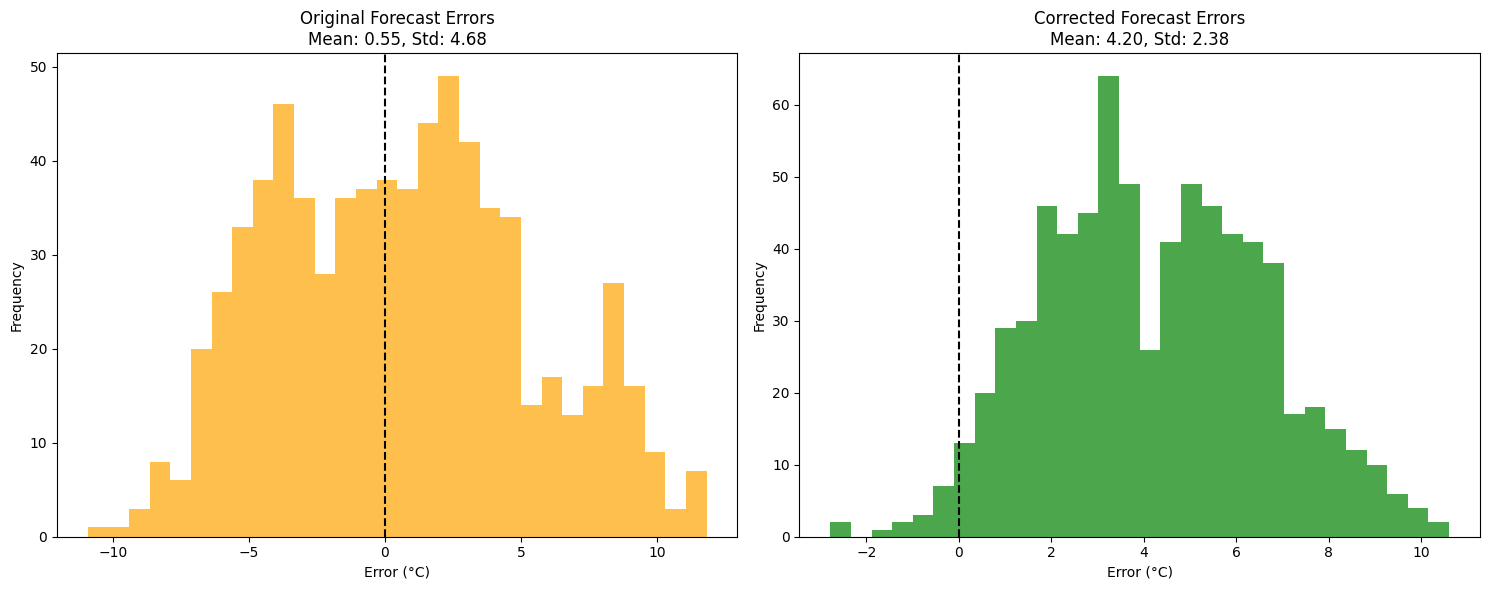

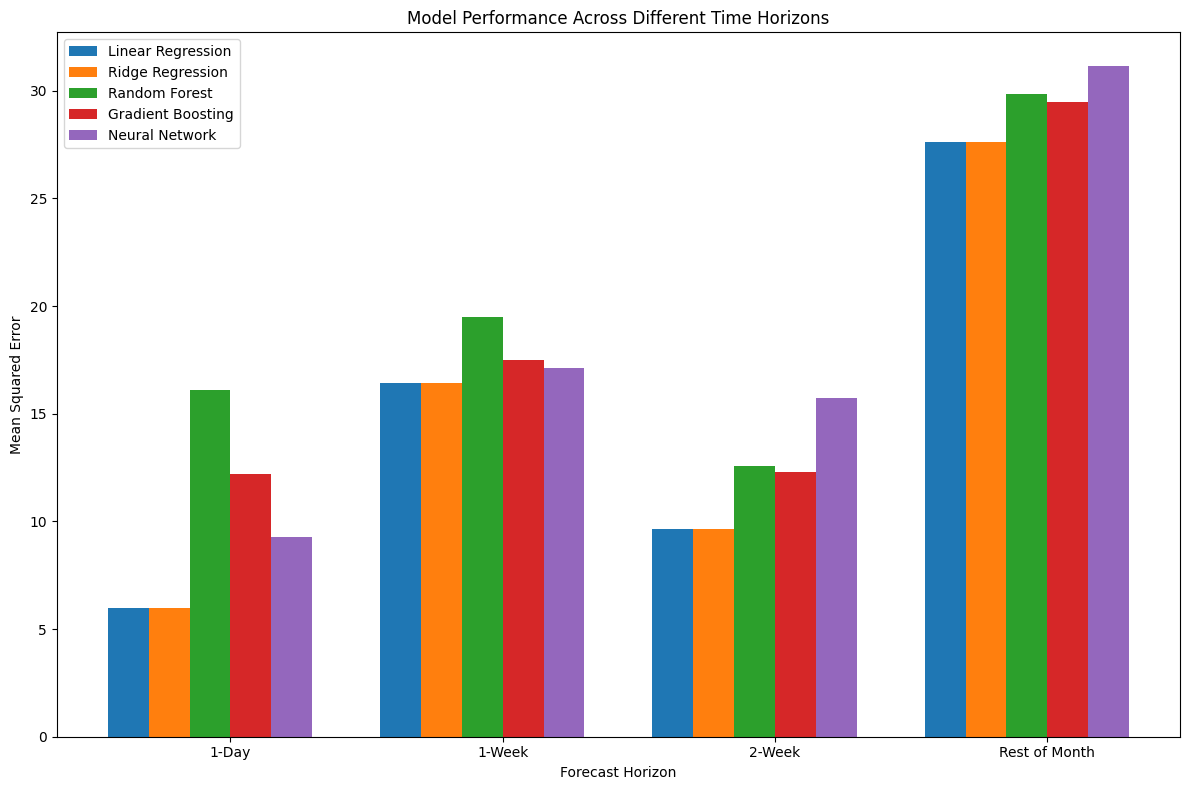

In [12]:
# ────────────────────────────────────────────────────────────────────────────
# 8️⃣ Regression Correction Model using Validation Data
import os, re, time
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Reshape the data for regression
# Concatenate all validation periods for training
X_train = validation_predictions_cleaned.reshape(-1, 1)  # Flattened predictions as features
y_train = validation_actuals.reshape(-1)                 # Flattened actuals as targets

print(f"Training regression model on {X_train.shape[0]} validation examples")

# Create and train multiple regression models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Neural Network": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42))
    ])
}

# Dictionary to store the trained models
trained_models = {}
model_scores = {}

# Train each model and evaluate
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model

    # Predict on the training data to evaluate
    y_pred = model.predict(X_train)

    # Calculate metrics
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    model_scores[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Find the best model based on MSE
best_model_name = min(model_scores.keys(), key=lambda k: model_scores[k]['MSE'])
best_model = trained_models[best_model_name]
print(f"\nBest model based on MSE: {best_model_name}")

# ────────────────────────────────────────────────────────────────────────────
# 9️⃣ Apply correction to the original forecast
# Load or use the final forecast data (preds) from earlier part of your code
# Using preds and preds_cleaned_iqr (the IQR-cleaned original predictions)

print("\nApplying correction model to the forecast data...")

# Create input features for the correction model
X_forecast = preds_cleaned_iqr.reshape(-1, 1)

# Apply the best correction model
corrected_forecast = best_model.predict(X_forecast)

# ────────────────────────────────────────────────────────────────────────────
# 🔟 Evaluate and visualize original vs. corrected predictions
# Using next_month_actual (the actual values for the forecast period)

# Calculate metrics for the original and corrected forecasts
original_mse = mean_squared_error(next_month_actual, preds_cleaned_iqr)
corrected_mse = mean_squared_error(next_month_actual, corrected_forecast)

original_mae = mean_absolute_error(next_month_actual, preds_cleaned_iqr)
corrected_mae = mean_absolute_error(next_month_actual, corrected_forecast)

print(f"\nOriginal Forecast - MSE: {original_mse:.4f}, MAE: {original_mae:.4f}")
print(f"Corrected Forecast - MSE: {corrected_mse:.4f}, MAE: {corrected_mae:.4f}")
print(f"Improvement: {(original_mse - corrected_mse) / original_mse * 100:.2f}% reduction in MSE")

# Plot the actual values, original predictions, and corrected predictions
hours = np.arange(len(next_month_actual))

plt.figure(figsize=(15, 6))
plt.plot(hours, next_month_actual, label="Actual Temperatures", color='blue')
plt.plot(hours, preds_cleaned_iqr, label="LLM Forecast (Cleaned)", color='orange', linestyle='--')
plt.plot(hours, corrected_forecast, label="Corrected Forecast", color='green', linestyle='-')
plt.xlabel("Hour (from forecast start)")
plt.ylabel("Temperature (°C)")
plt.title("30-Day Hourly Temperature Forecast: Original vs. Corrected vs. Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────
# Bonus: Plot the error distribution before and after correction
plt.figure(figsize=(15, 6))

# Original errors
original_errors = preds_cleaned_iqr - next_month_actual
plt.subplot(1, 2, 1)
plt.hist(original_errors, bins=30, alpha=0.7, color='orange')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f"Original Forecast Errors\nMean: {np.mean(original_errors):.2f}, Std: {np.std(original_errors):.2f}")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")

# Corrected errors
corrected_errors = corrected_forecast - next_month_actual
plt.subplot(1, 2, 2)
plt.hist(corrected_errors, bins=30, alpha=0.7, color='green')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f"Corrected Forecast Errors\nMean: {np.mean(corrected_errors):.2f}, Std: {np.std(corrected_errors):.2f}")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────
# Bonus: Analysis of which model performs best across different time horizons
# This helps understand if certain models are better for short-term vs. long-term predictions

# Define time horizon segments (e.g., 1-day, 1-week, 2-week, etc.)
horizons = [
    (0, 24),       # 1 day
    (24, 168),     # 2-7 days (1 week)
    (168, 336),    # 8-14 days (2 weeks)
    (336, 720)     # 15-30 days (rest of month)
]

horizon_names = ["1-Day", "1-Week", "2-Week", "Rest of Month"]

# Compute MSE for each model and time horizon
horizon_results = {}

for name, model in trained_models.items():
    # Apply the model to get corrected predictions
    model_corrected = model.predict(X_forecast)

    horizon_mse = []
    for i, (start, end) in enumerate(horizons):
        # Calculate MSE for this horizon
        horizon_mse.append(mean_squared_error(
            next_month_actual[start:end],
            model_corrected[start:end]
        ))

    horizon_results[name] = horizon_mse

# Plot the results
plt.figure(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(horizons))

for i, (name, results) in enumerate(horizon_results.items()):
    plt.bar(index + i * bar_width, results, bar_width, label=name)

plt.xlabel('Forecast Horizon')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Across Different Time Horizons')
plt.xticks(index + bar_width * (len(trained_models) / 2), horizon_names)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Heuristic Feeback Loop for residual correction

# Use a feedback factor (how much of the previous residual to apply)
feedback_strength = 0.1  # You can tune this (0.1–0.3 is usually stable)

# Initialize
corrected_forecast_feedback = []
previous_residual = 0

for i in range(len(preds_cleaned_iqr)):
    current_pred = preds_cleaned_iqr[i]

    # Apply a fraction of the last residual to correct this prediction
    corrected = current_pred - feedback_strength * previous_residual

    corrected_forecast_feedback.append(corrected)

    # Now compute new residual (actual - predicted)
    # This assumes we have access to actuals (during testing/eval)
    if i < len(next_month_actual):
        previous_residual = corrected - next_month_actual[i]

corrected_forecast_feedback = np.array(corrected_forecast_feedback)



🔄 Feedback-Heuristic Correction - MSE: 18.4017, MAE: 3.5493
Improvement over original: 16.95%


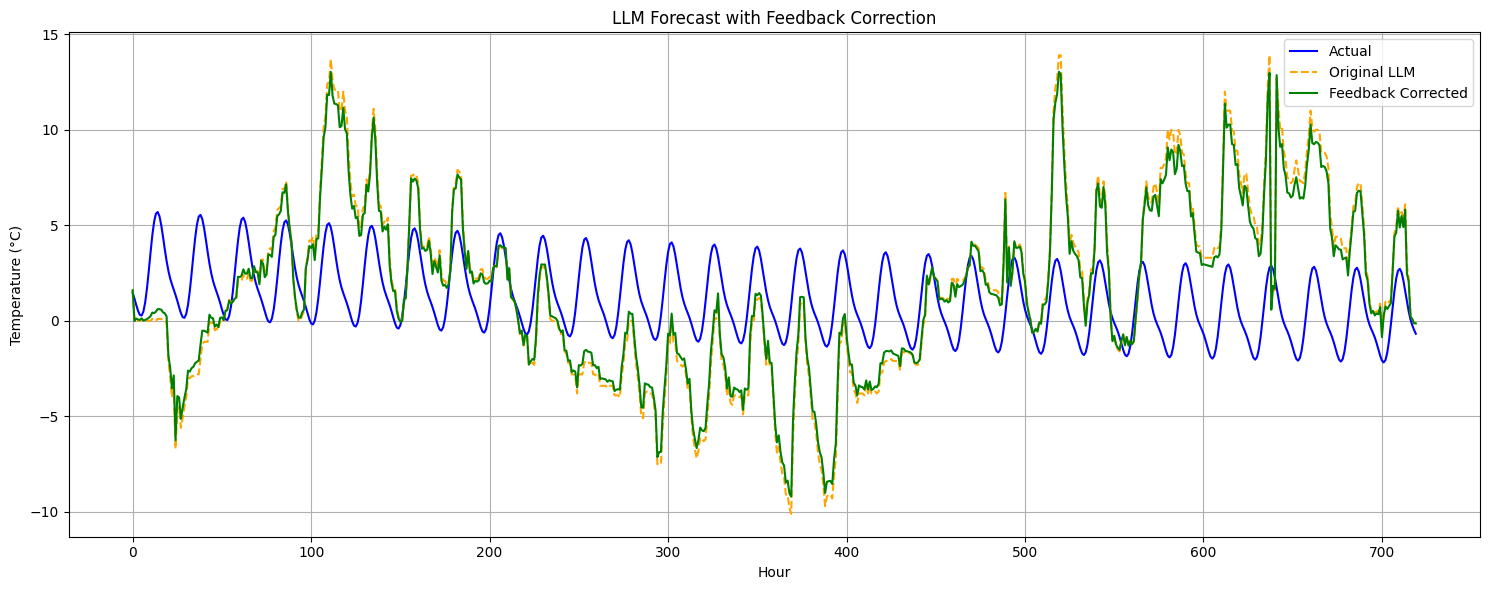

In [14]:
# Metrics
feedback_mse = mean_squared_error(next_month_actual, corrected_forecast_feedback)
feedback_mae = mean_absolute_error(next_month_actual, corrected_forecast_feedback)

print(f"\n🔄 Feedback-Heuristic Correction - MSE: {feedback_mse:.4f}, MAE: {feedback_mae:.4f}")
print(f"Improvement over original: {(original_mse - feedback_mse) / original_mse * 100:.2f}%")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(hours, next_month_actual, label="Actual", color='blue')
plt.plot(hours, preds_cleaned_iqr, label="Original LLM", color='orange', linestyle='--')
plt.plot(hours, corrected_forecast_feedback, label="Feedback Corrected", color='green', linestyle='-')
plt.title("LLM Forecast with Feedback Correction")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Finetuning

In [2]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
# If you need to authenticate for private or gated models:
token = os.getenv("HF_TOKEN")  # ✅ much safer

# Load the dataset
df = (
    pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
      .sort_values("Formatted Date")
      .reset_index(drop=True)
)

# Settings
FEATURE = "Temperature (C)"
LOOKBACK = 8640   # 1 year of hourly samples
HORIZON = 720     # 30 days × 24 hours

# Prepare the input data
temps = df[FEATURE].values[-LOOKBACK:]
assert temps.shape[0] == LOOKBACK

# Prepare the prompt string
temps_list = [round(float(x), 1) for x in temps]
input_str = ",".join(str(x) for x in temps_list)

prompt = (
    f"Given the past {LOOKBACK} hourly temperatures: [{input_str}], "
    f"predict the next {HORIZON} hourly temperatures. "
    "Reply with a comma‑separated list of numbers."
)

# Load the model and tokenizer
model_path = "/content/drive/MyDrive/Colab Notebooks/FineTuned_Mistral"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,             # Use float16 if available
    device_map="cuda"              # Distribute layers smartly
)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import time
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the prompt
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    truncation=True,
    max_length=8192
).to(device)

# Generate prediction
start = time.time()
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4096,   # Enough space for 720 numbers
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
elapsed = time.time() - start
print(f"Single-shot generation took {elapsed:.1f} seconds")

# Decode and extract float values
resp = tokenizer.decode(outputs[0], skip_special_tokens=True)
resp = resp.replace(prompt, "")  # Optional cleanup
nums = re.findall(r"[-+]?\d*\.\d+|\d+", resp)
preds_new = [float(x) for x in nums[:HORIZON]]

print(f"\nParsed {len(preds_new)} hourly predictions.")
#print(preds)

# Get ground truth
actual_values = df[FEATURE].values[-HORIZON:]


Single-shot generation took 213.1 seconds

Parsed 720 hourly predictions.


Found 4 outliers in predictions. Replacing with median: 1.60

📊 Metrics After Outlier Replacement:
RMSE: 22.158
MAE : 3.898
R²  : -5.353


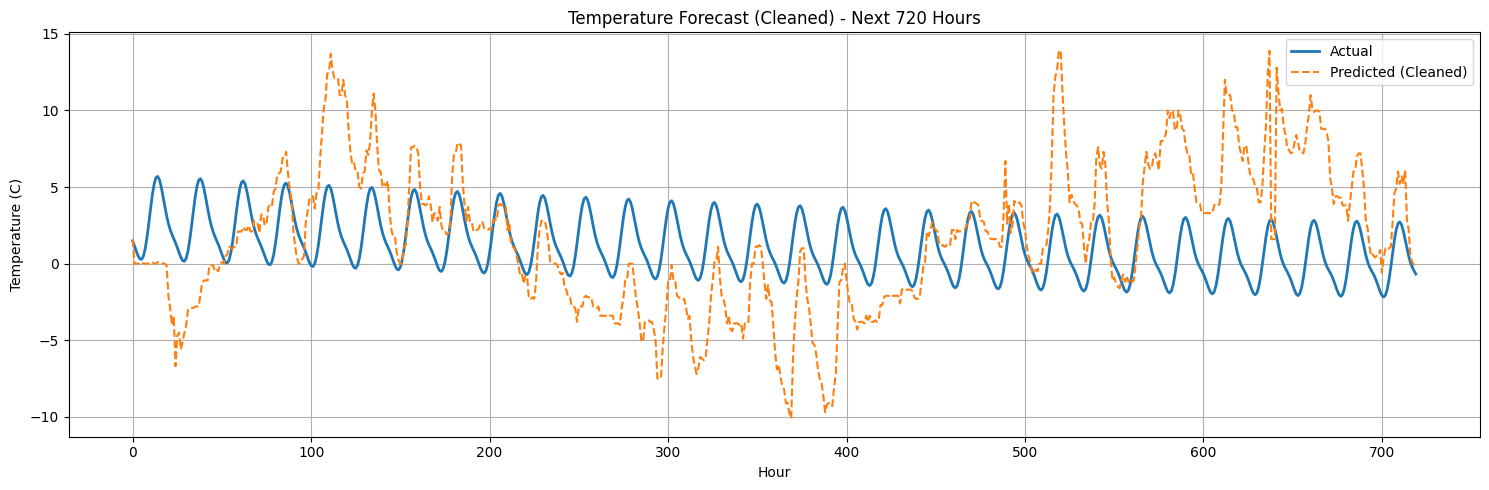

In [4]:
# Assuming preds is your list of 720 predictions from earlier
preds_new_cleaned = np.array(preds_new)

# Calculate IQR
Q1 = np.percentile(preds_new_cleaned, 25)
Q3 = np.percentile(preds_new_cleaned, 75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier indices
outlier_indices = np.where((preds_new_cleaned < lower_bound) | (preds_new_cleaned > upper_bound))[0]

# Replace outliers with the median
median_pred = np.median(preds_new_cleaned)
if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outliers in predictions. Replacing with median: {median_pred:.2f}")
    preds_new_cleaned[outlier_indices] = median_pred
else:
    print("No outliers detected.")

# Optional: Re-evaluate after cleaning
rmse_clean = mean_squared_error(actual_values, preds_new_cleaned)
mae_clean = mean_absolute_error(actual_values, preds_new_cleaned)
r2_clean = r2_score(actual_values, preds_new_cleaned)

print(f"\n📊 Metrics After Outlier Replacement:")
print(f"RMSE: {rmse_clean:.3f}")
print(f"MAE : {mae_clean:.3f}")
print(f"R²  : {r2_clean:.3f}")

# Plot cleaned predictions
plt.figure(figsize=(15, 5))
plt.plot(actual_values, label="Actual", linewidth=2)
plt.plot(preds_new_cleaned, label="Predicted (Cleaned)", linestyle='--')
plt.title("Temperature Forecast (Cleaned) - Next 720 Hours")
plt.xlabel("Hour")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
